Setup and Data Extraction

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip /content/gdrive/MyDrive/Eyes.zip -d /content/

Archive:  /content/gdrive/MyDrive/Eyes2.zip
   creating: /content/Eyes/
   creating: /content/Eyes/test/
   creating: /content/Eyes/test/cataract/
 extracting: /content/Eyes/test/cataract/cataract-101.jpg  
 extracting: /content/Eyes/test/cataract/cataract-106.jpg  
 extracting: /content/Eyes/test/cataract/cataract-135.jpg  
 extracting: /content/Eyes/test/cataract/cataract-154.jpg  
 extracting: /content/Eyes/test/cataract/cataract-176.jpg  
 extracting: /content/Eyes/test/cataract/cataract-18.jpg  
  inflating: /content/Eyes/test/cataract/cataract-199.jpg  
  inflating: /content/Eyes/test/cataract/cataract-202.jpg  
  inflating: /content/Eyes/test/cataract/cataract-204.jpg  
  inflating: /content/Eyes/test/cataract/cataract-205.jpg  
  inflating: /content/Eyes/test/cataract/cataract-207.jpg  
  inflating: /content/Eyes/test/cataract/cataract-208.jpg  
  inflating: /content/Eyes/test/cataract/cataract-212.jpg  
  inflating: /content/Eyes/test/cataract/cataract-215.jpg  
  inflating: /

Importing Neccesary Libraries

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Flatten, Dense

Data Preprocessing

In [ ]:
img_height, img_width = 64, 64
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    "Eyes/train",
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "Eyes/validation",
    image_size=(img_height, img_width),
    batch_size=batch_size
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    "Eyes/test",
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 560 files belonging to 2 classes.
Found 120 files belonging to 2 classes.
Found 120 files belonging to 2 classes.


Model Construction

In [ ]:
class_names = ["cataract", "healthy"]

base_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the base model's layers
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dense(2)  
])

80134624/80134624 [==============================] - 1s 0us/step



Compile the model

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

Training the model

In [ ]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
25/25 [==============================] - 79s 3s/step - loss: 6.4813 - accuracy: 0.7952 - val_loss: 1.0065 - val_accuracy: 0.9056
Epoch 2/10
25/25 [==============================] - 74s 3s/step - loss: 0.5821 - accuracy: 0.9372 - val_loss: 0.3382 - val_accuracy: 0.9485
Epoch 3/10
25/25 [==============================] - 77s 3s/step - loss: 0.2294 - accuracy: 0.9724 - val_loss: 0.4532 - val_accuracy: 0.9185
Epoch 4/10
25/25 [==============================] - 74s 3s/step - loss: 0.0950 - accuracy: 0.9786 - val_loss: 0.3228 - val_accuracy: 0.9742
Epoch 5/10
25/25 [==============================] - 75s 3s/step - loss: 0.0334 - accuracy: 0.9937 - val_loss: 0.3683 - val_accuracy: 0.9700
Epoch 6/10
25/25 [==============================] - 74s 3s/step - loss: 0.0597 - accuracy: 0.9937 - val_loss: 0.1539 - val_accuracy: 0.9785
Epoch 7/10
25/25 [==============================] - 88s 3s/step - loss: 0.0062 - accuracy: 0.9975 - val_loss: 0.1747 - val_accuracy: 0.9742
Epoch 8/10
25/25 [==

Evaluate the model

In [ ]:
model.evaluate(test_ds)

8/8 [==============================] - 16s 2s/step - loss: 0.1353 - accuracy: 0.9822


[0.13525082170963287, 0.9822221994400024]

Visualization of the Predictions

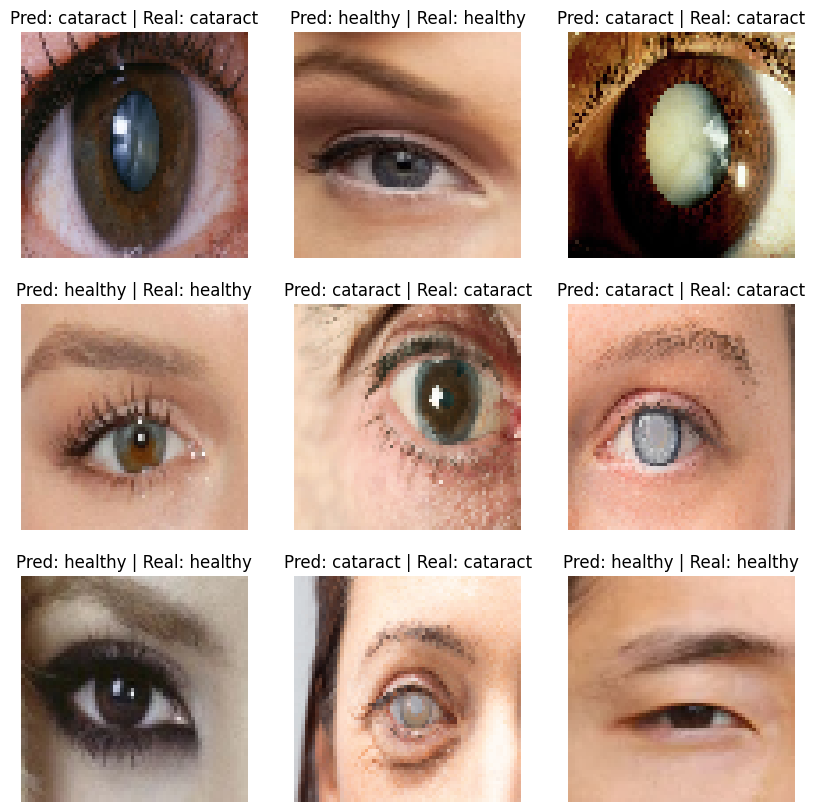

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
    classifications = model(images)

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        index = np.argmax(classifications[i])
        plt.title("Pred: " + class_names[index] + " | Real: " + class_names[labels[i]])
        plt.axis("off")

Tflite Conversion


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", 'wb') as f:
  f.write(tflite_model)

Average runtime calculation

In [ ]:
import time
# Define a function to measure the execution time of a single run
def measure_execution_time(model, input_data):
    start_time = time.time()
    model.predict(input_data)
    end_time = time.time()
    execution_time = end_time - start_time
    return execution_time
# Run multiple iterations and measure the execution time for each iteration
num_iterations = 5  
total_execution_time = 0

for _ in range(num_iterations):
    execution_time = measure_execution_time(model, test_ds)
    total_execution_time += execution_time

average_execution_time = total_execution_time / num_iterations

print("Average Execution Time:", average_execution_time)

8/8 [==============================] - 19s 2s/step
Average Execution Time: 18.744876194000245


Total Trainable Parameters

In [ ]:
trainable_params = tf.reduce_sum([tf.reduce_prod(variable.shape) for variable in model.trainable_variables])
print("Trainable Parameters:", trainable_params.numpy())

Trainable Parameters: 262530


Calculate precision, recall, and F1 score

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Predict classes for the test dataset
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(predicted_classes)

# Calculate precision, recall, and F1 score
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

1/1 [==============================] - 0s 233ms/step
Precision: 0.9823705578403459
Recall: 0.9822222222222222
F1 Score: 0.9822187088274045


Plot Confusion matrix

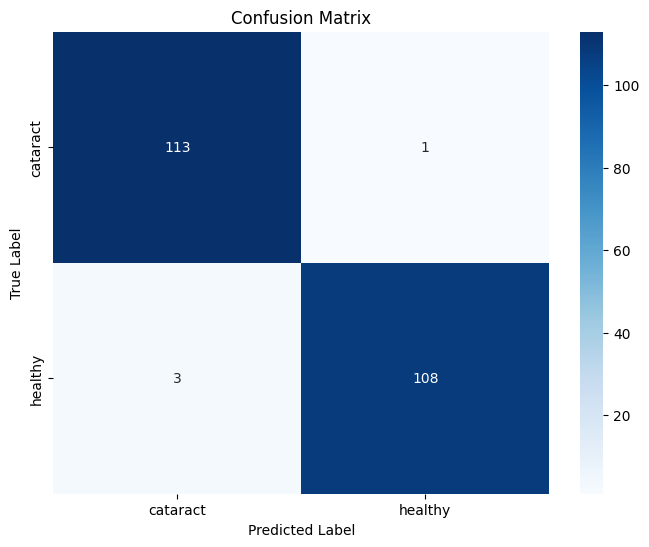

In [ ]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Plot ROC curve

1/1 [==============================] - 0s 78ms/step


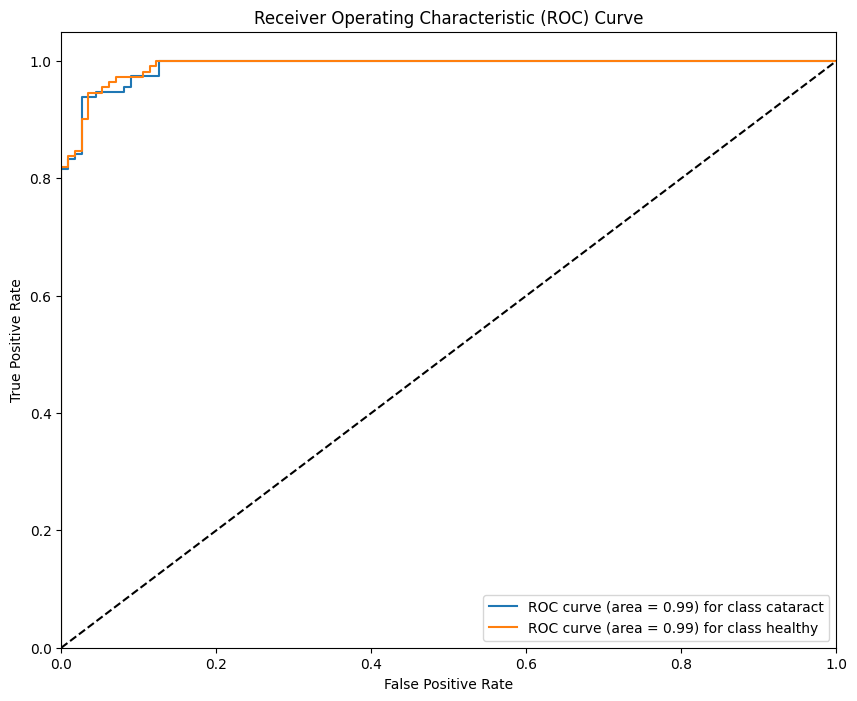

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.utils import to_categorical

# Predict probabilities for the test dataset
y_true = []
y_pred_probs = []

for images, labels in test_ds:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred_probs.extend(predictions)

# Convert the true labels to one-hot encoding
y_true = to_categorical(y_true, num_classes=len(class_names))

# Calculate ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], np.array(y_pred_probs)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for class {class_names[i]}')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()